#### Import Libraries

In [25]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import *
%run utils.py         #to run every update in utils.py till code complition

#from model import Net
%run model.py


!pip install torchsummary #Installs torch summary, if not available
from torchsummary import summary

<Figure size 640x480 with 0 Axes>

#### Find Mean and Standard Deviation of the Data set

In [26]:
simple_transforms = transforms.Compose([ transforms.ToTensor() ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#### Data Transformations
We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [27]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

#### Dataset and Creating Train/Test Split

In [28]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

#### Dataloader Arguments & Test/Train Dataloaders

In [29]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


#### Analyse and View the Data

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


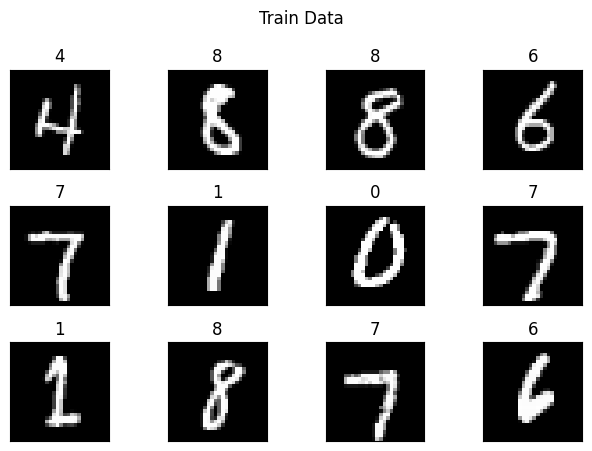

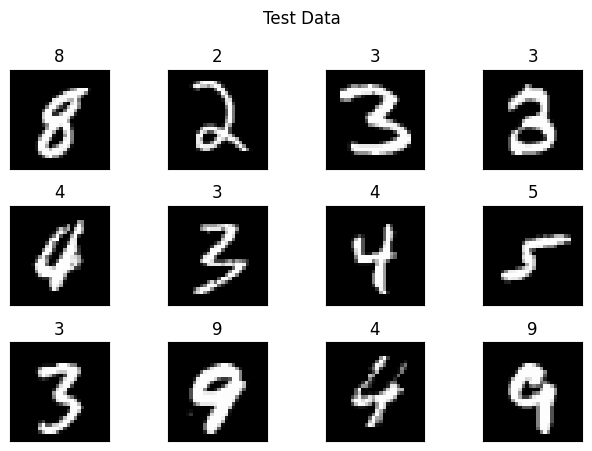

In [30]:
# Lets check the Statistics of the training dataset
stats_dataset(train_data)

# View the Training and Test Data
view_dataset(train_loader, "Train Data")
view_dataset(test_loader, "Test Data")

In [31]:
from torchsummary import summary
device = setDevice()
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]           1,152
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6            [-1, 8, 13, 13]             128
              ReLU-7            [-1, 8, 13, 13]               0
            Conv2d-8           [-1, 16, 13, 13]           1,152
              ReLU-9           [-1, 16, 13, 13]               0
           Conv2d-10           [-1, 32, 11, 11]           4,608
             ReLU-11           [-1, 32, 11, 11]               0
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Conv2d-13             [-1, 16, 5, 5]             512
             ReLU-14       

#### Training and Testing the model

In [32]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = F.nll_loss
num_epoch = 15

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)


Epoch :  0


Train: Loss=2.3007 Batch_id=468 Accuracy=10.86: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]


Test set: Average loss: 2.3014, Accuracy: 959/10000 (9.59%)

Epoch :  1


Train: Loss=0.1119 Batch_id=468 Accuracy=57.14: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]


Test set: Average loss: 0.1941, Accuracy: 9417/10000 (94.17%)

Epoch :  2


Train: Loss=0.1667 Batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]


Test set: Average loss: 0.1401, Accuracy: 9547/10000 (95.47%)

Epoch :  3


Train: Loss=0.0492 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]


Test set: Average loss: 0.0628, Accuracy: 9788/10000 (97.88%)

Epoch :  4


Train: Loss=0.0630 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]


Test set: Average loss: 0.0544, Accuracy: 9822/10000 (98.22%)

Epoch :  5


Train: Loss=0.0437 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]


Test set: Average loss: 0.0555, Accuracy: 9826/10000 (98.26%)

Epoch :  6


Train: Loss=0.0680 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]


Test set: Average loss: 0.0503, Accuracy: 9840/10000 (98.40%)

Epoch :  7


Train: Loss=0.1493 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]


Test set: Average loss: 0.0516, Accuracy: 9829/10000 (98.29%)

Epoch :  8


Train: Loss=0.0342 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]


Test set: Average loss: 0.0399, Accuracy: 9873/10000 (98.73%)

Epoch :  9


Train: Loss=0.0563 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]


Test set: Average loss: 0.0437, Accuracy: 9858/10000 (98.58%)

Epoch :  10


Train: Loss=0.0122 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]


Test set: Average loss: 0.0409, Accuracy: 9874/10000 (98.74%)

Epoch :  11


Train: Loss=0.0870 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]


Test set: Average loss: 0.0391, Accuracy: 9874/10000 (98.74%)

Epoch :  12


Train: Loss=0.0446 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]


Test set: Average loss: 0.0528, Accuracy: 9841/10000 (98.41%)

Epoch :  13


Train: Loss=0.0041 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]


Test set: Average loss: 0.0367, Accuracy: 9886/10000 (98.86%)

Epoch :  14


Train: Loss=0.0573 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]


Test set: Average loss: 0.0349, Accuracy: 9891/10000 (98.91%)



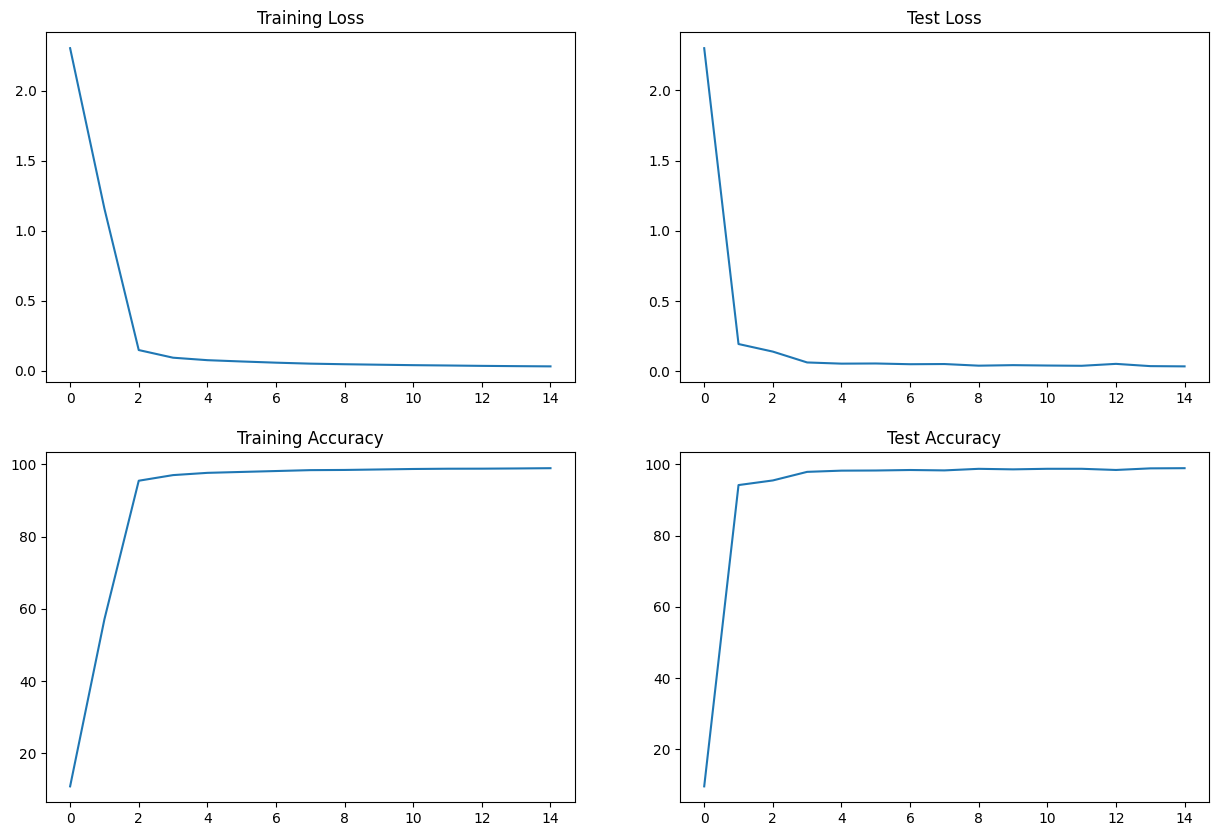

In [33]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)